# V-10 flight simulation
This notebook is being developed by the avionics and flight dynamics sub-teams in The Rocket Launchers student organization at the University of Texas Rio Grande Valley. Our rocket's name is V-10 in celebration of our club's 10th anniversary! V-10 will be competing in the 10k COTS division at Lonestar cup 2026 and IREC 2026.


Key features of V-10:
- Air brakes
- vonKarman Nose Cone
- Replaceable fins


In [145]:
# Import RocketPy classes for simulation components
# Environment: atmospheric conditions and launch site
# SolidMotor: rocket motor thrust and geometry
# Rocket: main rocket assembly with mass and aerodynamic properties
# Flight: flight simulation engine
# Aerodynamic surfaces: TrapezoidalFins, EllipticalFins, NoseCone, Tail
# Recovery: Parachute
# Rail components: RailButtons
from rocketpy import Environment, SolidMotor, Rocket, Flight, TrapezoidalFins, EllipticalFins, RailButtons, NoseCone, Tail, Parachute
import datetime

## Shared Configuration

V-10 uses a shared configuration module (`rocket_config.py`) that contains all rocket parameters. This ensures consistency between:
- Flight simulation (this notebook)
- 3D visualization (launch_viewer.py)
- Any other tools or analysis scripts

The configuration module provides factory functions to create:
- `create_environment()` - atmospheric conditions
- `create_motor()` - AeroTech M2500T motor
- `create_rocket()` - complete rocket assembly
- Individual components: nose cone, fins, boat tail, parachutes

You can either use these factory functions directly, or work with the individual parameter constants for educational purposes or custom configurations.

In [146]:
# Import the shared configuration module
# This module contains all V-10 rocket parameters and factory functions
import rocket_config

# You have two options for using the configuration:

# OPTION 1: Use factory functions (Quick & Easy)
# Uncomment these lines to create rocket components directly:
# env = rocket_config.create_environment()
# rocket = rocket_config.create_rocket()
# This creates the complete rocket assembly in 2 lines!

# OPTION 2: Use individual constants (Educational & Customizable)
# Access configuration constants for learning or custom modifications:
# rocket_config.ROCKET_BODY_RADIUS
# rocket_config.FIN_COUNT
# rocket_config.NOSECONE_LENGTH
# etc.

# This notebook uses OPTION 2 to show each step of the assembly process
# for educational purposes. Both options create identical rockets.

### Benefits of Shared Configuration

**Single Source of Truth:**
- All rocket parameters defined once in `rocket_config.py`
- Changes automatically propagate to both notebook and 3D viewer
- Eliminates version drift between simulation and visualization

**Example:** If you update the fin dimensions in `rocket_config.py`:
```python
FIN_ROOT_CHORD = 0.32  # Changed from 0.3048
```
Both the flight simulation AND the 3D viewer will use the new value immediately.

**Quick Assembly Option:**
For rapid prototyping or analysis, you can skip all the detailed cells below and just use:
```python
rocket = rocket_config.create_rocket()
```
This creates the complete V-10 assembly in one line, identical to the step-by-step approach.

## Environment

The Environment object simulates real-world atmospheric conditions and geographic location for accurate flight trajectory predictions.

**Location Variables:**
- `launch_latitude`: geographic latitude in degrees (positive = North, negative = South)
- `launch_longitude`: geographic longitude in degrees (positive = East, negative = West)  
- `launch_elevation`: altitude of launch site above mean sea level in meters

**Why Location Matters:**
Geographic location affects the simulation through:
- **Gravity variations**: gravitational acceleration varies slightly with latitude (centrifugal effects)
- **Atmospheric density**: elevation determines initial air density at launch
- **Weather patterns**: GFS forecast data is location-specific
- **Earth rotation effects**: Coriolis forces influence trajectory at different latitudes

**Atmospheric Model:**
The environment uses **GFS (Global Forecast System)** weather forecast data to provide realistic atmospheric conditions throughout the flight:
- **Air density (ρ)**: decreases exponentially with altitude, directly affects drag force magnitude
- **Temperature (T)**: affects speed of sound (a = √(γRT)) and therefore Mach number calculations
- **Pressure (P)**: influences air density through ideal gas law (ρ = P/RT)
- **Wind velocity**: causes trajectory drift and affects relative airspeed

**Drag Force Dependency:**
All atmospheric properties feed into the drag force equation:  
**F_drag = 0.5 × ρ(altitude) × v_relative² × Cd(Mach) × A_ref**

where air density ρ varies with altitude according to the atmospheric model, and Mach number depends on local temperature.

**V-10 Launch Sites:**
- **Rocket Ranch** (Seymour, TX): Primary testing location - currently configured
- **IREC** (Spaceport America, Las Cruces, NM): Competition site for June 2026

In [147]:
# Create environment object and configure launch site location
env = Environment()

# ==================== LAUNCH SITE CONFIGURATIONS ====================
# V-10 Mission Launch Sites (from rocket_config.py)

# Launch Site 1: Rocket Ranch - Seymour, Texas (Primary Testing Location)
# Used for: Pre-competition test flights, airbrakes testing, recovery validation
rocket_ranch_latitude = rocket_config.ROCKET_RANCH_LATITUDE
rocket_ranch_longitude = rocket_config.ROCKET_RANCH_LONGITUDE
rocket_ranch_elevation = rocket_config.ROCKET_RANCH_ELEVATION

# Launch Site 2: Spaceport America - Las Cruces, New Mexico (IREC Competition)
# Used for: Intercollegiate Rocket Engineering Competition (IREC) June 2026
spaceport_america_latitude = rocket_config.SPACEPORT_AMERICA_LATITUDE
spaceport_america_longitude = rocket_config.SPACEPORT_AMERICA_LONGITUDE
spaceport_america_elevation = rocket_config.SPACEPORT_AMERICA_ELEVATION

# ==================== ACTIVE LAUNCH SITE ====================
# Currently configured for: ROCKET RANCH (Seymour, TX)
# These values come from rocket_config.py - change there to update everywhere
launch_latitude = rocket_config.LAUNCH_LATITUDE
launch_longitude = rocket_config.LAUNCH_LONGITUDE
launch_elevation = rocket_config.LAUNCH_ELEVATION

# Set environment to active launch site
env.set_location(latitude=launch_latitude, longitude=launch_longitude)
env.set_elevation(launch_elevation)

print(f"Launch site configured: Rocket Ranch, Seymour, TX")
print(f"Coordinates: {launch_latitude}°N, {launch_longitude}°W")
print(f"Elevation: {launch_elevation} m ASL")

Launch site configured: Rocket Ranch, Seymour, TX
Coordinates: 33.49862509998744°N, -99.3376124767802°W
Elevation: 417.0 m ASL


Optionally, you can set the date and atmospheric model


In [148]:
# Set simulation date to tomorrow at noon (12:00)
# Uses GFS (Global Forecast System) atmospheric model for realistic weather conditions
tomorrow = datetime.date.today() + datetime.timedelta(days=1)
env.set_date((tomorrow.year, tomorrow.month, tomorrow.day, 12))
env.set_atmospheric_model(type='Forecast', file='GFS')


Gravity Details

Acceleration of gravity at surface level:    9.7790 m/s²
Acceleration of gravity at  78.978 km (ASL): 9.5410 m/s²


Launch Site Details

Launch Date: 2025-11-02 12:00:00 UTC
Launch Site Latitude: 33.49863°
Launch Site Longitude: -99.33761°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 166021.44 W|E    0.00 N
Launch Site UTM zone: 31N
Launch Site Surface Elevation: 416.7 m


Atmospheric Model Details

Atmospheric Model Type: Forecast
Forecast Maximum Height: 78.978 km
Forecast Time Period: from 2025-11-01 06:00:00 to 2025-11-17 06:00:00 utc
Forecast Hour Interval: 3 hrs
Forecast Latitude Range: From -90.0° to 90.0°
Forecast Longitude Range: From 0.0° to 359.75°

Surface Atmospheric Conditions

Surface Wind Speed: 2.75 m/s
Surface Wind Direction: 170.73°
Surface Wind Heading: 350.73°
Surface Pressure: 974.50 hPa
Surface Temperature: 281.93 K
Surface Air Density: 1.204 kg/m³
Surface Speed of Sound: 336.60 m/s


Earth Model Details

Earth Radius at Launch site:

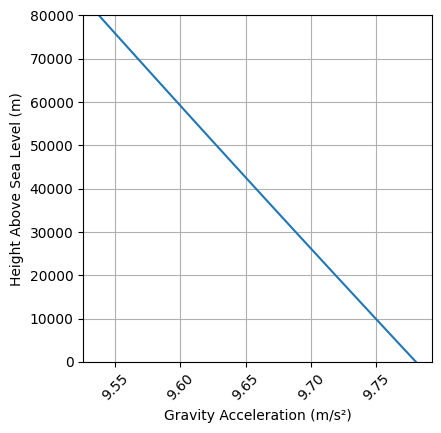



Atmospheric Model Plots


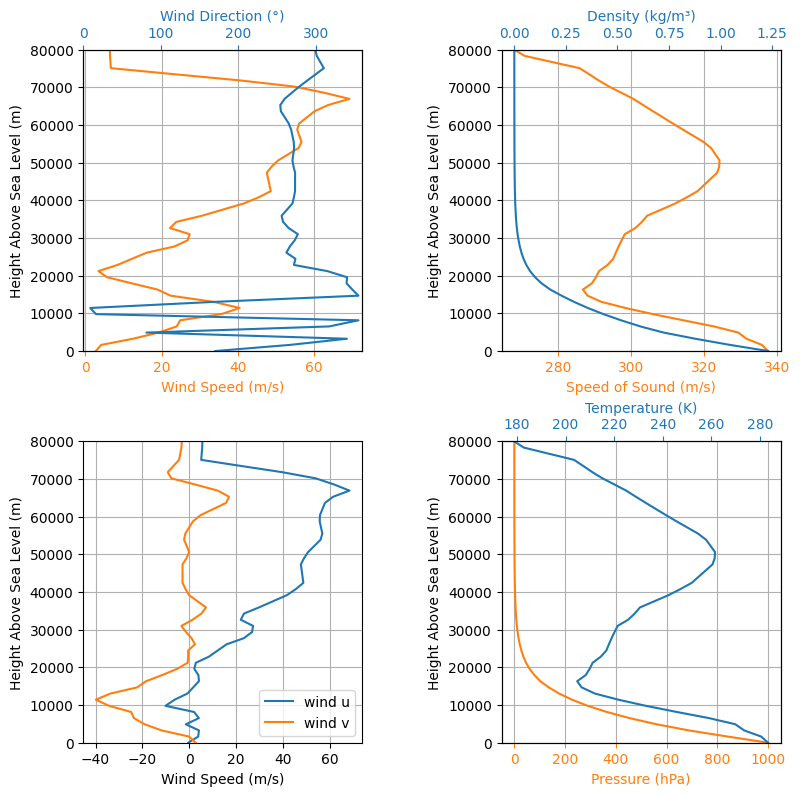

In [149]:
# Display complete environment information including:
# - Launch site coordinates and elevation
# - Date and time of simulation
# - Atmospheric conditions (temperature, pressure, wind)
# - Weather model data source
env.all_info()

## Motor

V-10 uses an AeroTech M2500T (98 mm) solid motor. The motor configuration includes:

**Geometry Variables:**
- `motor_grain_outer_radius`: outer radius of propellant grain
- `motor_grain_inner_radius`: inner hollow core radius  
- `motor_grain_height`: axial length of propellant grain
- `motor_nozzle_radius`: nozzle exit radius
- `motor_throat_radius`: nozzle throat radius (minimum flow area)

**Mass Variables:**
- `motor_dry_mass`: mass of motor casing without propellant
- `motor_grain_density`: propellant density used to calculate propellant mass

**Position:**
- `motor_nozzle_position`: distance from grain center to nozzle

The thrust curve is loaded from the local ENG file. Motor orientation is set to `combustion_chamber_to_nozzle` to align with the rocket's coordinate system.

In [150]:
# Motor geometry and mass parameters (from rocket_config.py)
motor_dry_mass = rocket_config.MOTOR_DRY_MASS
motor_grain_density = rocket_config.MOTOR_GRAIN_DENSITY
motor_grain_outer_radius = rocket_config.MOTOR_GRAIN_OUTER_RADIUS
motor_grain_inner_radius = rocket_config.MOTOR_GRAIN_INNER_RADIUS
motor_grain_height = rocket_config.MOTOR_GRAIN_HEIGHT
motor_nozzle_radius = rocket_config.MOTOR_NOZZLE_RADIUS
motor_throat_radius = rocket_config.MOTOR_THROAT_RADIUS
motor_nozzle_position = rocket_config.MOTOR_NOZZLE_POSITION

# Create SolidMotor object with AeroTech M2500T specifications using the smoothed .eng file
m2500t = SolidMotor(
    thrust_source='../../data/AeroTech_M2500T_smoothed.eng',
    dry_mass=motor_dry_mass,
    center_of_dry_mass_position=0,
    dry_inertia=[0, 0, 0],
    grains_center_of_mass_position=0,
    grain_number=1,
    grain_density=motor_grain_density,
    grain_outer_radius=motor_grain_outer_radius,
    grain_initial_inner_radius=motor_grain_inner_radius,
    grain_initial_height=motor_grain_height,
    grain_separation=0,
    nozzle_radius=motor_nozzle_radius,
    nozzle_position=motor_nozzle_position,
    throat_radius=motor_throat_radius,
    reshape_thrust_curve=False,
    interpolation_method='linear',
    coordinate_system_orientation='combustion_chamber_to_nozzle',
)

Nozzle Details
Nozzle Radius: 0.036750000000000005 m
Nozzle Throat Radius: 0.0245 m

Grain Details
Number of Grains: 1
Grain Spacing: 0 m
Grain Density: 1137.5 kg/m3
Grain Outer Radius: 0.049 m
Grain Inner Radius: 0.0245 m
Grain Height: 0.732 m
Grain Volume: 0.004 m3
Grain Mass: 4.710 kg

Motor Details
Total Burning Time: 3.9001 s
Total Propellant Mass: 4.710 kg
Structural Mass Ratio: 0.416
Average Propellant Exhaust Velocity: 1920.912 m/s
Average Thrust: 2320.051 N
Maximum Thrust: 3431.51 N at 1.4601 s after ignition.
Total Impulse: 9048.431 Ns



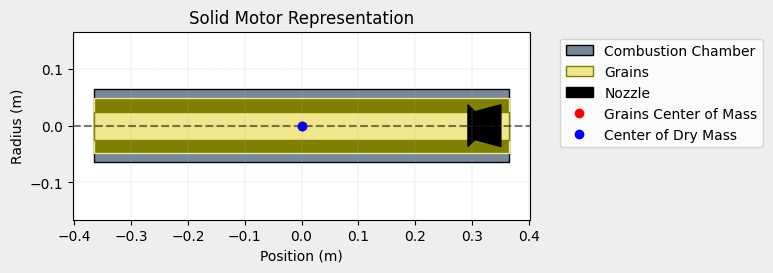

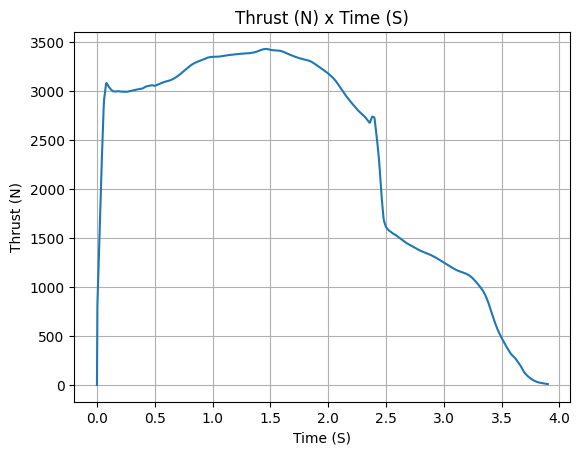

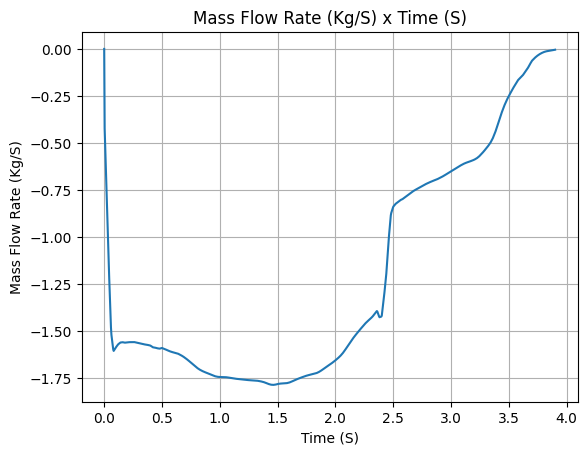

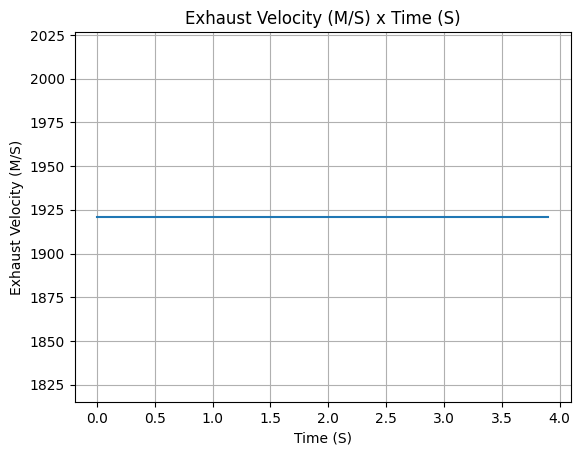

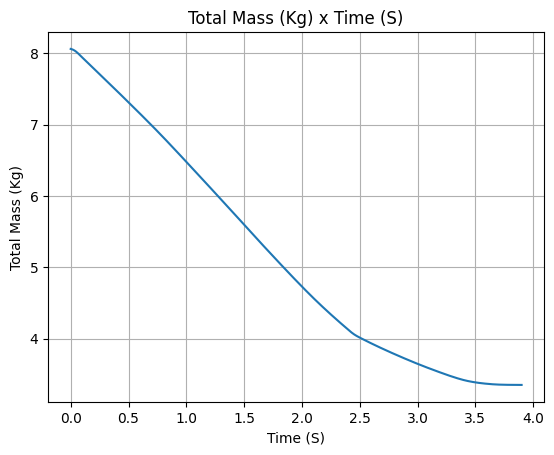

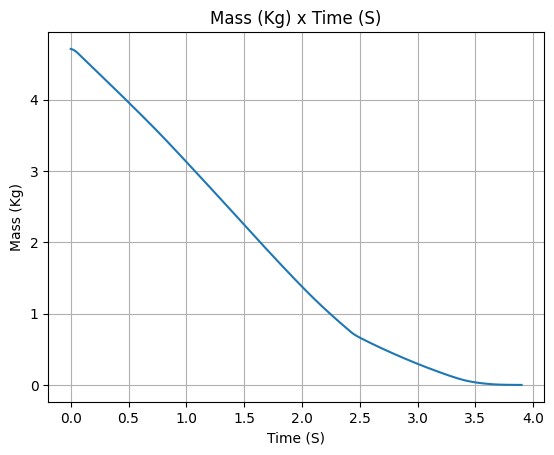

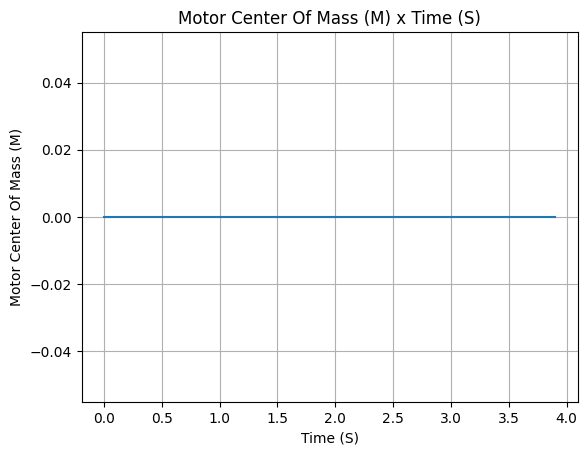

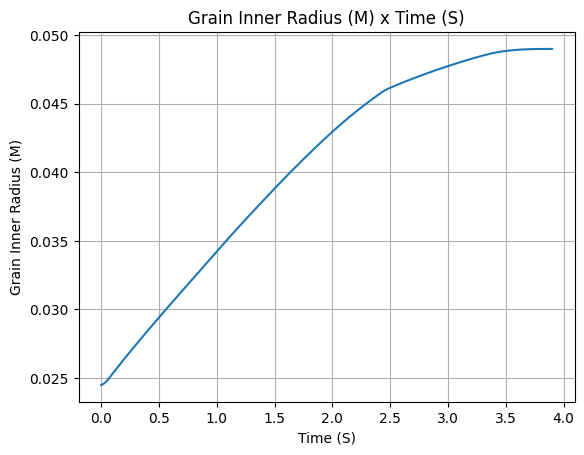

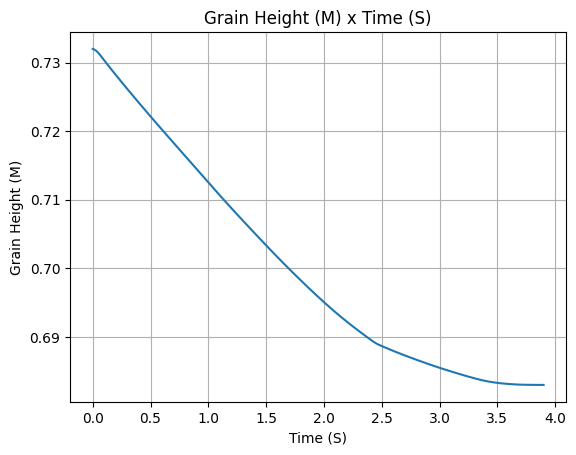

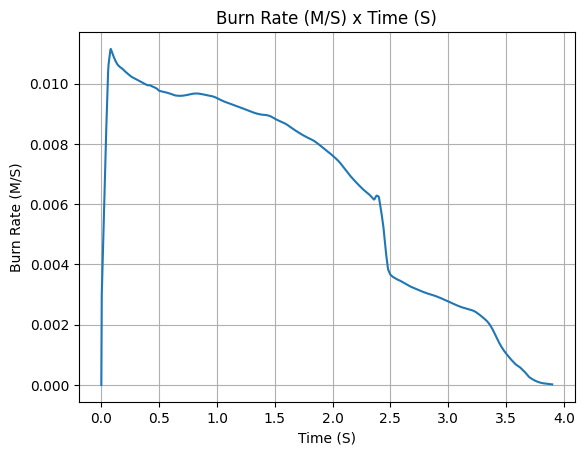

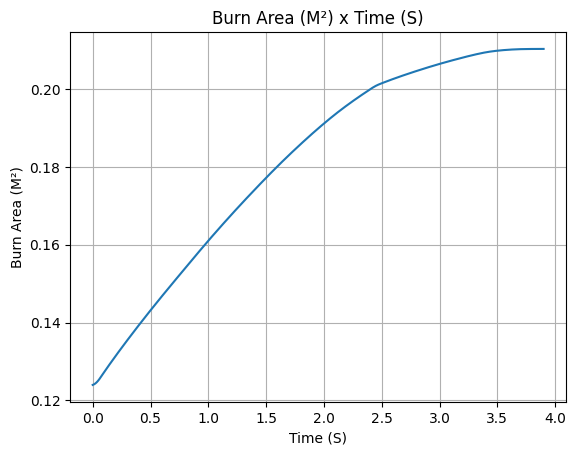

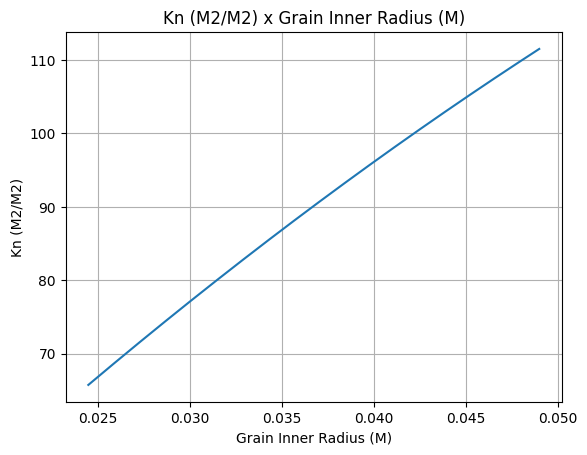

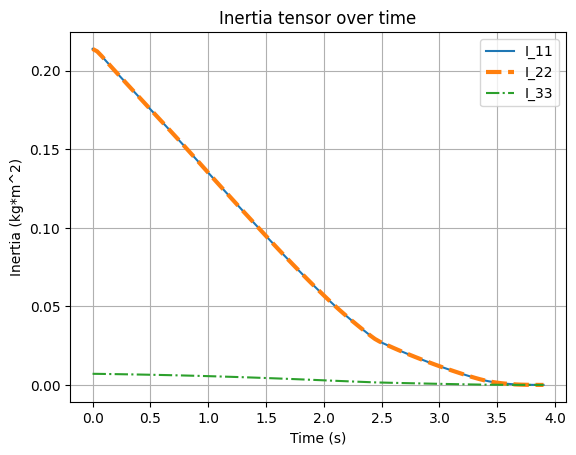

In [151]:
# Display complete motor information including:
# - Thrust curve and performance characteristics
# - Grain geometry and mass properties
# - Nozzle dimensions
# - Center of mass evolution during burn
m2500t.all_info()

## Rocket Assembly

V-10 is a single-stage rocket. The rocket assembly combines aerodynamic surfaces with mass/inertia properties and drag models.

**Key Dimensional Variables:**
- `rocket_body_radius`: reference radius defining the main body tube diameter and reference area for drag calculations

**Mass Properties:**
- `rocket_dry_mass`: total rocket mass without motor
- `rocket_com_without_motor`: center of mass position from nose tip (without motor)
- `rocket_inertia_i`: moment of inertia about pitch/yaw axes (Ixx = Iyy)
- `rocket_inertia_z`: moment of inertia about roll axis (Izz)

**Drag Models:**
- `cd_power_off`: drag coefficient vs Mach number after motor burnout
- `cd_power_on`: drag coefficient vs Mach number during motor burn

The coordinate system uses `nose_to_tail` orientation, with positive distances measured from the nose tip toward the tail.

Next, we define individual aerodynamic surfaces (nose cone, fins, boat tail) before assembling the complete rocket.

### Nose Cone

V-10 uses a **Von Kármán (Haack series)** nose cone optimized for minimum drag at supersonic speeds.

**Dimensional Variables:**
- `nosecone_length`: axial length from tip to base
- `nosecone_base_radius`: radius at the base (matches body tube)
- `rocket_body_radius`: main body tube radius for proper attachment

**Drag Contribution:**
The Von Kármán shape minimizes **wave drag** at supersonic speeds by optimizing the volume distribution along the nose. This reduces the strength of shock waves formed at the nose tip during high-speed flight. The nose cone contributes to the overall rocket drag coefficient through:
- **Form drag**: shape-dependent pressure distribution
- **Wave drag**: shock wave formation at supersonic speeds (minimized by Von Kármán profile)
- **Skin friction drag**: surface friction along the nose cone length

In [152]:
# Nose cone dimensions (from rocket_config.py)
nosecone_length = rocket_config.NOSECONE_LENGTH
nosecone_base_radius = rocket_config.NOSECONE_BASE_RADIUS
rocket_body_radius = rocket_config.ROCKET_BODY_RADIUS

# Create Von Karman nose cone (optimized for minimum drag at supersonic speeds)
# The Von Karman shape minimizes wave drag and is ideal for high-speed flight
nosecone = NoseCone(
    length=nosecone_length,
    kind='Von Karman',
    base_radius=nosecone_base_radius,
    rocket_radius=rocket_body_radius,
    name='Nose Cone',
)

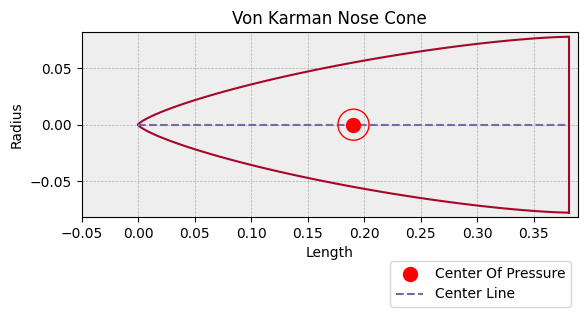

In [153]:
# Display nose cone profile visualization
# Shows the aerodynamic shape and dimensions
nosecone.draw()

### Fins

V-10 features trapezoidal fins for aerodynamic stability. The fin geometry is approximated from the V-10 freeform design.

**Fin Dimensional Variables:**
- `fin_count`: number of fins around the body
- `fin_root_chord`: length of fin along the body (root attachment)
- `fin_tip_chord`: length of fin at the outer tip
- `fin_span`: height of fin perpendicular to body (extends radially outward)
- `fin_sweep_length`: horizontal distance from root leading edge to tip leading edge (determines sweep angle)

**Drag Contribution:**
Fins contribute to drag through multiple mechanisms:
- **Skin friction drag**: surface area of fin exposed to airflow
- **Form drag**: pressure drag from fin thickness and profile
- **Induced drag**: generated when fins produce lift at angle of attack (stabilizing the rocket)
- **Interference drag**: additional drag at the fin-body junction due to flow interaction
- **Wave drag** (supersonic): shock waves formed at fin leading edges and body-fin junctions

The fin sweep angle (determined by `fin_sweep_length`) helps reduce wave drag at supersonic speeds by angling the leading edge relative to the airflow.

In [154]:
# Fin dimensions (from rocket_config.py)
fin_count = rocket_config.FIN_COUNT
fin_root_chord = rocket_config.FIN_ROOT_CHORD
fin_tip_chord = rocket_config.FIN_TIP_CHORD
fin_span = rocket_config.FIN_SPAN
fin_sweep_length = rocket_config.FIN_SWEEP_LENGTH

# Create trapezoidal fins
# Fins provide aerodynamic stability and generate lift-induced drag
# Drag contribution: form drag from fin thickness, induced drag from lift at angle of attack
fins = TrapezoidalFins(
    n=fin_count,
    root_chord=fin_root_chord,
    tip_chord=fin_tip_chord,
    span=fin_span,
    sweep_length=fin_sweep_length,
    rocket_radius=rocket_body_radius,
    name="CF Trapezoidal (approx from V-10)",
)

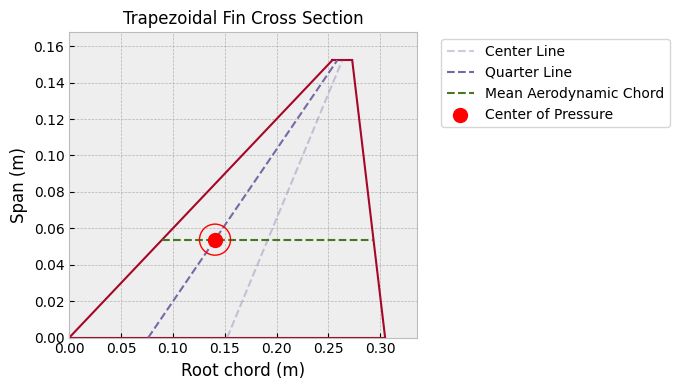

In [155]:
# Display fin planform (top-down view) showing geometry
# Visualizes the trapezoidal shape with sweep angle
fins.draw()

### Transitions (Tails)

The boat tail is a conical transition at the rocket's aft end that reduces base drag.

**Boat Tail Dimensional Variables:**
- `boattail_top_radius`: radius at the forward end (matches main body tube)
- `boattail_bottom_radius`: smaller radius at the aft end
- `boattail_length`: axial length of the transition

**Drag Contribution:**
The boat tail serves to reduce **base drag** (pressure drag in the wake region). Key effects:
- **Base pressure recovery**: the tapered shape helps streamline airflow, reducing the low-pressure wake region behind the rocket
- **Flow separation control**: gradual diameter reduction delays or controls boundary layer separation
- **Wave drag reduction** (supersonic): smoother geometric transition reduces shock strength at the aft end

Without a boat tail, the blunt base would create significant pressure drag due to flow separation and wake formation. The conical taper (`boattail_top_radius` to `boattail_bottom_radius`) allows the flow to close more gradually, increasing base pressure and reducing overall drag.

In [156]:
# Initialize dictionary to store tail/transition sections
# Tails create aerodynamic transitions between different body diameters
tails = {}

In [157]:
# Boat tail dimensions (from rocket_config.py)
boattail_top_radius = rocket_config.BOATTAIL_TOP_RADIUS
boattail_bottom_radius = rocket_config.BOATTAIL_BOTTOM_RADIUS
boattail_length = rocket_config.BOATTAIL_LENGTH

# Create boat tail component
# Boat tail reduces base drag by smoothing airflow transition at the rocket's aft end
# Helps reduce pressure drag in the wake region behind the rocket
tails[0] = Tail(
    top_radius=boattail_top_radius,
    bottom_radius=boattail_bottom_radius,
    length=boattail_length,
    rocket_radius=rocket_body_radius,
    name='Boat Tail',
)

### Parachutes

V-10 uses a two-stage recovery system with drogue and main parachutes.

**Parachute Drag Variables:**

**Main Parachute:**
- `main_chute_cd`: drag coefficient of the main parachute canopy
- `main_chute_diameter`: diameter when fully inflated
- `main_chute_area`: reference area (π × (diameter/2)²)
- `main_chute_cd_s`: effective drag area (Cd × area), used directly in drag force calculation
- `main_deploy_altitude`: altitude trigger for deployment

**Drogue Parachute:**
- `drogue_chute_cd`: drag coefficient of the drogue parachute
- `drogue_chute_diameter`: smaller diameter for controlled descent
- `drogue_chute_area`: reference area
- `drogue_chute_cd_s`: effective drag area

**Drag Force Calculation:**
Parachute drag force follows: **F_drag = 0.5 × ρ × v² × CdS**

where `CdS` is the product of drag coefficient and reference area. The drogue deploys at apogee to stabilize and slow initial descent, while the main parachute deploys at lower altitude for safe landing.

In [158]:
# Initialize dictionary to store parachute recovery components
parachutes = {}

In [159]:
# Main parachute drag parameters (from rocket_config.py)
main_chute_cd = rocket_config.MAIN_CHUTE_CD
main_chute_diameter = rocket_config.MAIN_CHUTE_DIAMETER
main_chute_area = 3.14159 * (main_chute_diameter / 2) ** 2  # m² - reference area
main_chute_cd_s = main_chute_cd * main_chute_area  # m² - effective drag area (CdS)
main_deploy_altitude = rocket_config.MAIN_DEPLOY_ALTITUDE

# Create main parachute with deployment trigger
# CdS (drag coefficient × area) determines the drag force: F_drag = 0.5 × ρ × v² × CdS
parachutes[0] = Parachute(
    name='Main Parachute + Bag',
    cd_s=main_chute_cd_s,
    trigger=main_deploy_altitude,
    sampling_rate=100, 
)

In [160]:
# Drogue parachute drag parameters (from rocket_config.py)
drogue_chute_cd = rocket_config.DROGUE_CHUTE_CD
drogue_chute_diameter = rocket_config.DROGUE_CHUTE_DIAMETER
drogue_chute_area = 3.14159 * (drogue_chute_diameter / 2) ** 2  # m² - reference area
drogue_chute_cd_s = drogue_chute_cd * drogue_chute_area  # m² - effective drag area (CdS)

# Create drogue parachute that deploys at apogee (highest point)
# Drogue slows descent and stabilizes rocket before main chute deployment
parachutes[1] = Parachute(
    name='Drogue',
    cd_s=drogue_chute_cd_s,
    trigger='apogee',
    sampling_rate=100, 
)

### Rocket Drag Coefficients

The rocket's total drag is characterized by **drag coefficient (Cd)** as a function of Mach number. We define separate curves for:
- **Power-off drag** (`cd_power_off`): drag after motor burnout
- **Power-on drag** (`cd_power_on`): drag during motor burn (includes base drag effects from exhaust plume)

Drag varies with Mach number due to:
- **Subsonic (M < 0.9)**: primarily skin friction and form drag from body and fins
- **Transonic (0.9 < M < 1.2)**: wave drag increases dramatically near M=1 due to shock formation
- **Supersonic (M > 1.2)**: wave drag from nose cone, body, and fins dominates

The `rocket_body_radius` defines the reference area (A_ref = π × radius²) used in drag force calculation:  
**F_drag = 0.5 × ρ × v² × Cd × A_ref**

Below we define Cd vs Mach arrays with initial estimates. These should be refined with CFD analysis or flight data.

### Applying CFD Analysis to Drag Coefficients

**For Flight Dynamics Team: How to Use CFD Results**

When you obtain drag coefficients from Computational Fluid Dynamics (CFD) analysis, you need to understand what to simulate and how to apply the results to this flight simulation.

#### Option 1: Full Rocket CFD (Recommended for Accuracy)

**What to simulate:** 
- Complete rocket assembly including nose cone, body tube, fins, and boat tail as a single geometry
- Run simulations across Mach numbers: 0.0, 0.5, 0.9, 1.0, 1.2, 2.0, 3.0 (minimum)
- Simulate both power-on (with exhaust plume) and power-off configurations

**How to apply results:**
1. Extract total Cd values at each Mach number from CFD post-processing
2. Create [Mach, Cd] pairs from your CFD data
3. Replace the `cd_power_off` and `cd_power_on` arrays with your CFD results
4. The rocket reference area is automatically calculated from `rocket_body_radius`

**Advantages:**
- Most accurate - captures all interaction effects between components
- Accounts for interference drag at fin-body and nose-body junctions
- Includes base drag effects and wake interactions
- No need to combine separate component drag values

**CFD Setup Requirements:**
- Include exhaust plume geometry/boundary condition for power-on case
- Ensure proper boundary layer resolution (y+ < 1 for accurate skin friction)
- Use compressible flow solver for transonic/supersonic regimes

---

#### Option 2: Component-by-Component CFD (More Work, Educational)

**What to simulate:**
- Nose cone alone (cone + cylindrical body section)
- Fins alone (single fin or fin set on cylinder)
- Boat tail alone (transition geometry)

**How to apply results:**
If you choose this approach, you'll need to:
1. Get Cd values for each component at each Mach number
2. Calculate total Cd by **summing** component contributions (with caution)
3. Apply correction factors for interference drag (typically 5-15% increase)

**Important Notes:**
- **RocketPy already models individual surfaces** (nose cone, fins, tail) internally
- The `cd_power_off` and `cd_power_on` arrays represent the **total rocket Cd**
- If using component CFD, you're essentially validating/improving RocketPy's built-in models
- Component drag values **do not add linearly** - you must account for:
  - **Interference drag**: additional drag at component junctions
  - **Mutual flow interaction**: fins affect body flow, nose affects fin flow
  - **Wake effects**: upstream components affect downstream drag

**This approach is NOT recommended** unless you're conducting detailed aerodynamic studies, because:
- More simulations required (3-4× the computational cost)
- Must manually combine results with interference factors
- RocketPy's geometric methods already provide good component estimates
- Full-rocket CFD gives better results with less effort

---

#### Option 3: Hybrid Approach (Component Validation)

**Recommended workflow:**
1. Run **full rocket CFD** to get total Cd values → use for flight simulation
2. Run **component CFD** separately to validate and understand contributions
3. Compare component CFD to RocketPy's internal component drag breakdown
4. Use insights to refine rocket geometry for drag reduction

---

#### Updating Drag Coefficients with CFD Data

**Example:** If your CFD analysis produces these results:

```python
# CFD-derived drag coefficients (example data)
cd_power_off_cfd = np.array([
    [0.00, 0.42],  # Your CFD result at M=0.0
    [0.50, 0.48],  # Your CFD result at M=0.5
    [0.90, 0.54],  # Your CFD result at M=0.9
    [1.00, 0.78],  # Your CFD result at M=1.0 (transonic peak)
    [1.20, 0.63],  # Your CFD result at M=1.2
    [2.00, 0.49],  # Your CFD result at M=2.0
])
```

Simply replace the current `cd_power_off` array with your CFD data. The simulation will interpolate between your data points.

---

#### Critical CFD Considerations

**Reference Area:**
- Ensure your CFD Cd is based on **body cross-sectional area** (π × `rocket_body_radius`²)
- RocketPy uses body area as reference, not fin area or wetted area
- If your CFD uses a different reference area, convert: Cd_body = Cd_other × (A_other / A_body)

**Mach Number Range:**
- Cover subsonic (M < 0.9), transonic (0.9-1.2), and supersonic (M > 1.2) regimes
- Transonic region (M ≈ 1.0) shows highest drag - ensure fine resolution here
- V-10 will likely experience M = 0 to ~2.5 during flight

**Power-On vs Power-Off:**
- **Power-on**: exhaust plume reduces base drag significantly (5-10% lower total Cd)
- **Power-off**: larger wake region increases base drag
- Model power-on with appropriate exhaust plume pressure/temperature boundary conditions

**Validation:**
- Compare CFD results to empirical methods (Barrowman, RASAero, OpenRocket)
- Check that Cd increases dramatically at M ≈ 1.0 (wave drag)
- Verify Cd decreases at higher supersonic Mach numbers
- Transonic peak should be Cd ≈ 0.7-0.8 for typical rockets

---

#### Current Drag Coefficients Status

The `cd_power_off` and `cd_power_on` arrays currently contain **initial estimates** based on typical rocket aerodynamics. These should be replaced with CFD-derived values for accurate flight predictions.

In [161]:
import numpy as np, csv, os

# Load cleaned Cd(Mach) from data/drag_curve_clean.csv (power-off baseline)
cd_clean_path = os.path.join('..','..','data','drag_curve_clean.csv')
M_list, Cd_list = [], []
with open(cd_clean_path, 'r', newline='') as f:
    reader = csv.DictReader(f)
    for row in reader:
        try:
            M = float(row.get('Mach') or row.get('mach') or row[list(row.keys())[0]])
            Cd = float(row.get('Cd_power_off') or row.get('cd') or row[list(row.keys())[1]])
        except Exception:
            continue
        M_list.append(M); Cd_list.append(Cd)

M_arr = np.array(M_list, dtype=float)
Cd_arr = np.array(Cd_list, dtype=float)
order = np.argsort(M_arr)
M_arr, Cd_arr = M_arr[order], Cd_arr[order]

# Build RocketPy arrays
cd_power_off = np.column_stack([M_arr, Cd_arr])
cd_power_on  = np.column_stack([M_arr, np.maximum(0.0, Cd_arr - 0.03)])  # small plume relief during burn

# Rocket mass and dimensional properties (from rocket_config.py)
rocket_dry_mass = rocket_config.ROCKET_DRY_MASS
rocket_inertia_i = rocket_config.ROCKET_INERTIA_I
rocket_inertia_z = rocket_config.ROCKET_INERTIA_Z
rocket_com_without_motor = rocket_config.ROCKET_COM_WITHOUT_MOTOR

# Create Rocket object with aerodynamic and mass properties
# The reference radius determines reference area for drag force calculations
# Using 'tail_to_nose' coordinate system: Z+ points UP (from tail toward nose)
rocket = Rocket(
    radius=rocket_body_radius,
    mass=rocket_dry_mass,
    inertia=[rocket_inertia_i, rocket_inertia_i, rocket_inertia_z],
    power_off_drag=cd_power_off,
    power_on_drag=cd_power_on,
    center_of_mass_without_motor=rocket_com_without_motor,
    coordinate_system_orientation='tail_to_nose',  # ✅ CORRECT: Z+ points UP
)

### Adding surfaces to the rocket

We attach aerodynamic surfaces at specific axial positions (measured from nose tip):
- **Nose cone** at position `nosecone_position`: the tip reference point
- **Fins** at position `fins_position`: root leading edge location
- **Boat tail** at position `boattail_position`: start of aft transition

Proper positioning is critical for accurate center of pressure and stability margin calculations. All positions follow the 'nose_to_tail' coordinate convention (positive direction toward tail).

In [162]:
# Axial positions for aerodynamic surfaces (from rocket_config.py)
# Using 'tail_to_nose' coordinate system: Z+ points UP (from tail to nose)
# - Nose at Z=0 (origin at nose tip)
# - Components toward tail have NEGATIVE Z positions

nosecone_position = rocket_config.NOSECONE_POSITION
fins_position = rocket_config.FINS_POSITION
boattail_position = rocket_config.BOATTAIL_POSITION

# Add all aerodynamic surfaces to the rocket at their specified positions
# This affects center of pressure calculation and overall stability
rocket.add_surfaces(surfaces=[nosecone, fins, tails[0]], positions=[nosecone_position, fins_position, boattail_position])

In [163]:
# Motor position (from rocket_config.py)
# Using 'tail_to_nose' coordinate system
# Motor is toward tail, so position is NEGATIVE
motor_position = rocket_config.MOTOR_POSITION

# Add motor to rocket
# Motor position affects center of mass location and mass distribution
rocket.add_motor(m2500t, position=motor_position)

Adding parachutes to the rocket


In [164]:
# Assign parachutes to rocket recovery system
# Converts dictionary to list and adds to rocket object
rocket.parachutes = list(parachutes.values())

### Rail Buttons

Rail buttons guide the rocket along the launch rail until sufficient velocity is achieved for aerodynamic stability. Positions are defined as:
- `upper_button_position`: distance from nose tip to upper button center
- `lower_button_position`: distance from nose tip to lower button center
- `angular_position`: rotational position around the body (degrees)

Proper spacing ensures smooth rail departure and prevents rail whip during launch.

In [165]:
# Rail button positions (from rocket_config.py)
# Using 'tail_to_nose' coordinate system
# Rail buttons are toward tail, so positions are NEGATIVE
upper_button_position = rocket_config.UPPER_BUTTON_POSITION
lower_button_position = rocket_config.LOWER_BUTTON_POSITION
button_angular_position = rocket_config.BUTTON_ANGULAR_POSITION

# Configure rail buttons on the rocket
# Rail buttons engage with launch rail to provide initial guidance
rail_buttons = rocket.set_rail_buttons(
   upper_button_position=upper_button_position,
   lower_button_position=lower_button_position,
   angular_position=button_angular_position,
)

### Virtual Sensors

V-10 includes a comprehensive sensor suite for flight data acquisition and state estimation. All sensors are mounted at the same location and aligned with the rocket's body axes for consistent measurements.

**Sensor Suite Components:**

1. **IMU (Inertial Measurement Unit)**
   - **Accelerometer**: Measures linear acceleration in 3 axes (X, Y, Z)
     - Measurement range: ±16g
     - Sampling rate: 100 Hz
     - Includes gravity in measurements for realistic attitude estimation
   - **Gyroscope**: Measures angular velocity (rotation rate) in 3 axes
     - Measurement range: ±500 deg/s (8.727 rad/s)
     - Sampling rate: 100 Hz
     - Used for attitude determination and rotation tracking

2. **Barometer**: Measures atmospheric pressure for altitude estimation
   - Sampling rate: 50 Hz
   - Provides backup altitude data independent of GNSS

3. **GNSS (GPS)**: Measures position and altitude
   - Sampling rate: 10 Hz
   - Position accuracy: ±3 meters (horizontal)
   - Altitude accuracy: ±5 meters (vertical)

**Sensor Alignment:**
- All sensors use orientation `(0, 0, 0)` = perfectly aligned with rocket body
- X and Y axes: perpendicular to rocket longitudinal axis
- Z-axis: along rocket longitudinal axis (tail to nose, matching rocket coordinate system)
- Mounted at position -1.5 m from nose (in tail_to_nose coordinates)

**Noise Modeling:**
Each sensor includes realistic noise characteristics:
- **Noise density**: High-frequency random noise
- **Random walk**: Low-frequency drift over time
- **Constant bias**: Fixed offset in measurements

These parameters simulate real MEMS sensor behavior for accurate hardware-in-the-loop testing.

In [ ]:
# Reload rocket_config to pick up the new sensor constants
import importlib
importlib.reload(rocket_config)

# Import sensor classes from RocketPy
from rocketpy.sensors import Accelerometer, Gyroscope, Barometer, GnssReceiver

# Sensor configuration parameters (from rocket_config.py)
sensor_position = rocket_config.SENSOR_POSITION
sensor_orientation = rocket_config.SENSOR_ORIENTATION

# Create accelerometer with realistic MEMS characteristics
# Aligned with rocket body: measures acceleration in rocket's X, Y, Z axes
accelerometer = Accelerometer(
    sampling_rate=rocket_config.IMU_SAMPLING_RATE,
    orientation=sensor_orientation,
    measurement_range=rocket_config.ACCEL_MEASUREMENT_RANGE,
    noise_density=rocket_config.ACCEL_NOISE_DENSITY,
    noise_variance=rocket_config.ACCEL_NOISE_VARIANCE,
    random_walk_density=rocket_config.ACCEL_RANDOM_WALK_DENSITY,
    random_walk_variance=rocket_config.ACCEL_RANDOM_WALK_VARIANCE,
    constant_bias=rocket_config.ACCEL_CONSTANT_BIAS,
    consider_gravity=rocket_config.ACCEL_CONSIDER_GRAVITY,
    name='V-10 Accelerometer',
)

# Create gyroscope for angular velocity measurement
# Aligned with rocket body: measures rotation rate around X, Y, Z axes
gyroscope = Gyroscope(
    sampling_rate=rocket_config.IMU_SAMPLING_RATE,
    orientation=sensor_orientation,
    measurement_range=rocket_config.GYRO_MEASUREMENT_RANGE,
    noise_density=rocket_config.GYRO_NOISE_DENSITY,
    noise_variance=rocket_config.GYRO_NOISE_VARIANCE,
    random_walk_density=rocket_config.GYRO_RANDOM_WALK_DENSITY,
    random_walk_variance=rocket_config.GYRO_RANDOM_WALK_VARIANCE,
    constant_bias=rocket_config.GYRO_CONSTANT_BIAS,
    name='V-10 Gyroscope',
)

# Create barometer for pressure-based altitude measurement
barometer = Barometer(
    sampling_rate=rocket_config.BARO_SAMPLING_RATE,
    measurement_range=rocket_config.BARO_MEASUREMENT_RANGE,
    noise_density=rocket_config.BARO_NOISE_DENSITY,
    noise_variance=rocket_config.BARO_NOISE_VARIANCE,
    random_walk_density=rocket_config.BARO_RANDOM_WALK_DENSITY,
    random_walk_variance=rocket_config.BARO_RANDOM_WALK_VARIANCE,
    constant_bias=rocket_config.BARO_CONSTANT_BIAS,
    name='V-10 Barometer',
)

# Create GNSS receiver for position and altitude measurement
gnss = GnssReceiver(
    sampling_rate=rocket_config.GNSS_SAMPLING_RATE,
    position_accuracy=rocket_config.GNSS_POSITION_ACCURACY,
    altitude_accuracy=rocket_config.GNSS_ALTITUDE_ACCURACY,
    name='V-10 GNSS',
)

# Add all sensors to the rocket at the same position
# All sensors are co-located and aligned with rocket body axes
rocket.add_sensor(accelerometer, sensor_position)
rocket.add_sensor(gyroscope, sensor_position)
rocket.add_sensor(barometer, sensor_position)
rocket.add_sensor(gnss, sensor_position)

print(f"✓ Added {len(rocket.sensors)} sensors to rocket")
print(f"  Sensor position: {sensor_position} m (tail_to_nose coordinate system)")
print(f"  Sensor orientation: {sensor_orientation}° (aligned with rocket body)")
print("\nSensor Details:")
for sensor_tuple in rocket.sensors:
    sensor_obj = sensor_tuple[0]
    print(f"  - {sensor_obj.name}")


AttributeError: module 'rocket_config' has no attribute 'SENSOR_POSITION'

### Accessing Sensor Data After Flight Simulation

After running the flight simulation, sensor data can be accessed through the `flight` object. Each sensor records measurements throughout the flight at its configured sampling rate.

**Example Usage:**

```python
# After running: flight = Flight(rocket=rocket, environment=env, ...)

# Access sensor data from flight object
# Sensor data is stored as time-series arrays

# Accelerometer data (m/s²)
accel_data = flight.accelerometer  # 3D acceleration measurements

# Gyroscope data (rad/s)
gyro_data = flight.gyroscope  # 3D angular velocity measurements

# Barometer data (Pa)
baro_data = flight.barometer  # Atmospheric pressure measurements

# GNSS data (m, degrees)
gnss_data = flight.gnss  # Position and altitude measurements
```

**Data Analysis:**
The sensor data can be used for:
- **State estimation**: Implementing Kalman filters to estimate position/velocity/attitude
- **Hardware-in-the-loop testing**: Feeding simulated sensor data to flight computer algorithms
- **Algorithm validation**: Testing air brake control algorithms with realistic sensor noise
- **Performance analysis**: Comparing sensor-based estimates with true flight trajectory

The sensors automatically include realistic noise and bias, making them ideal for testing sensor fusion algorithms and control systems before flight.

In [ ]:
# Display comprehensive rocket information including:
# - Mass properties (total mass, center of mass, inertia)
# - Aerodynamic properties (drag curves, surface contributions)
# - Geometric configuration (dimensions, component positions)
# - Stability analysis (center of pressure, static margin)
rocket.all_info()

## Flight Simulation

Now we create the flight simulation object with launch parameters:
- `rail_length`: length of launch rail in meters
- `inclination`: launch angle from horizontal (90° = vertical)
- `heading`: compass direction (0° = North, 90° = East)
- `max_time`: maximum simulation duration in seconds

The simulation integrates equations of motion considering thrust, drag, gravity, and aerodynamic forces.

In [ ]:
# Flight simulation parameters (from rocket_config.py)
rail_length = rocket_config.RAIL_LENGTH
launch_inclination = rocket_config.LAUNCH_INCLINATION
launch_heading = rocket_config.LAUNCH_HEADING
max_simulation_time = rocket_config.MAX_SIMULATION_TIME

# Create Flight simulation object
# Simulates rocket trajectory from launch through descent and landing
flight = Flight(
    rocket=rocket,
    environment=env,
    rail_length=rail_length,
    inclination=launch_inclination,
    heading=launch_heading,
    terminate_on_apogee=False,  # Continue simulation through descent
    max_time=max_simulation_time,
)

In [ ]:
# Display comprehensive flight analysis including:
# - Trajectory plots (altitude, velocity, acceleration vs time)
# - Maximum values (apogee, max velocity, max acceleration)
# - Stability metrics throughout flight
# - Recovery system deployment events
# - Impact conditions and landing location
print("Flight Summary:")
flight.all_info()